# Characteristic Extraction

## Preprocessing

In [ ]:
# downloads stanford dependency parser
!wget https://nlp.stanford.edu/software/stanford-corenlp-4.2.2.zip
!wget https://nlp.stanford.edu/software/stanford-corenlp-4.2.2-models-english.jar
!unzip /content/stanford-corenlp-4.2.2.zip

In [ ]:
# loads stanford dependency parser into python
from google.colab import drive
drive.mount('/content/drive')

from nltk.parse.stanford import StanfordDependencyParser
jar_path = 'stanford-corenlp-4.2.2/stanford-corenlp-4.2.2.jar'
models_jar_path = 'stanford-corenlp-4.2.2-models-english.jar'
parser = StanfordDependencyParser(path_to_jar = jar_path, path_to_models_jar = models_jar_path)

Mounted at /content/drive


<ipython-input-3-90e071890ef9>:8: DeprecationWarning: The StanfordDependencyParser will be deprecated
Please use nltk.parse.corenlp.CoreNLPDependencyParser instead.
  parser = StanfordDependencyParser(path_to_jar = jar_path, path_to_models_jar = models_jar_path)


In [ ]:
def get_nouns(reviews):
  '''
  given a list of reviews for the same movie, 
  calculates dependency tree for each review 
  take all nouns that are either subject or objects
  '''
  nouns = set()
  for idx, review in enumerate(reviews):
    try:
      result = parser.raw_parse(review)
      dependency = result.__next__()    
    except:
      'error processing ' + str(idx) + '/' + str(len(reviews))
      continue
    for dep in list(dependency.triples()):
      second, relation, first = dep 
      if relation == 'compound':
        nouns.add((first[0] + ' ' + second[0]).lower())
      elif (relation == 'nsubj' or relation == 'obj') and (first[1] == 'NN' or first[1] == 'NNS'):
        nouns.add(first[0].lower())
    print(str(idx + 1) + '/' + str(len(reviews)))
          
  return nouns

In [ ]:
def filter_via_support(nouns, reviews):
  '''
  given a list of nouns, calculate support in all reviews
  '''
  support_map = {noun: 0 for noun in nouns}
  for review in reviews:
    for noun in nouns:
      if noun in review:
        support_map[noun] += 1.0 / len(reviews)

  filtered_nouns = []
  for noun in support_map:
    if support_map[noun] > 0.1:
      filtered_nouns.append(noun)

  return filtered_nouns

# Summarization

In [ ]:
!pip install sentence-transformers

In [ ]:
import numpy as np
import nltk
from nltk.sentiment import SentimentIntensityAnalyzer
from collections import defaultdict 
nltk.download('vader_lexicon')
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

In [ ]:
def get_facet_groups(nouns, reviews):
  '''
  get all reviews associated with characteristic noun
  '''
  reviews_map = defaultdict(set)
  for noun in nouns:
    for review in reviews:
      if noun in review:
        reviews_map[noun].add(review)
  return reviews_map

In [ ]:
def get_polarity_groups(reviews_map):
  '''
  given facet groups, split it into positive and negative groups
  '''
  SA = SentimentIntensityAnalyzer()

  positive_groups = {}
  negative_groups = {}

  for noun in reviews_map:
    positive_groups[noun] = []
    negative_groups[noun] = []

    for review in reviews_map[noun]:
      polarity_score = SA.polarity_scores(review)
      if polarity_score['compound'] > 0:
        positive_groups[noun].append(review)
      else:
        negative_groups[noun].append(review)
  
  return positive_groups, negative_groups

In [ ]:
# cosine similarity
def sim(u, v):
    return np.dot(u, v) / (np.linalg.norm(u) * np.linalg.norm(v))

In [ ]:
def find_representative_sentence(cluster):
  '''
  given a list of reviews corresponding to the same characteristic + sentiment
  pick a representative sentence
  '''
  embeddings = sbert_model.encode(cluster)  

  max_sim = 0
  representative = ''

  for idx, embed1 in enumerate(embeddings):
    tot_sim = 0
    for embed2 in embeddings:
      tot_sim += sim(embed1, embed2)

    if tot_sim > max_sim:
      max_sim = tot_sim
      representative = cluster[idx]
  
  return representative

#Generate Summaries

In [ ]:
import csv
from collections import defaultdict

In [ ]:
# some movies don't have ground truth critic review summary
invalid_ids = set()
with open('drive/MyDrive/rotten_tomatoes_movies.csv', 'r') as file2:
  reader2 = csv.reader(file2)
  for idx, row in enumerate(reader2):
    if idx == 0:
      continue
    if len(row[3]) == 0:
      invalid_ids.add(row[0])

In [ ]:
id_to_reviews = defaultdict(list) # map movie_id to all reviews associated with the movie
ids_to_summarize = []

# hyperparameters
MAX_REVIEWS = 20
NUM_MOVIES = 5

with open('drive/MyDrive/rotten_tomatoes_critic_reviews.csv', 'r') as file:
  reader = csv.reader(file)
  for idx, row in enumerate(reader):
    if idx == 0 or row[0] in invalid_ids:
      continue 
    movie_id, review = row[0], row[-1]
    id_to_reviews[movie_id].append(review)

for movie_id in id_to_reviews:
  if len(id_to_reviews[movie_id]) <= MAX_REVIEWS:
    ids_to_summarize.append(movie_id)

    if len(ids_to_summarize) > NUM_MOVIES:
      break

In [ ]:
# get initial nouns for each movie
init_nouns = {}
for movie_id in ids_to_summarize:
  init_nouns[movie_id] = get_nouns(id_to_reviews[movie_id])

print(init_nouns)

1/18
2/18
3/18
4/18
5/18
6/18
7/18
8/18
9/18
10/18
11/18
12/18
13/18
14/18
15/18
16/18
17/18
0/10
1/10
2/10
3/10
4/10
5/10
6/10
7/10
8/10
9/10
1/5
2/5
3/5
4/5
0/20
1/20
2/20
3/20
4/20
5/20
6/20
7/20
8/20
9/20
10/20
11/20
12/20
13/20
14/20
15/20
16/20
17/20
18/20
19/20
0/19
1/19
8/19
9/19
10/19
12/19
13/19
14/19
15/19
16/19
17/19
18/19
6/13
8/13
9/13
10/13
11/13
12/13
{'m/10010131-scar': {'movie', 'porn industry', 'effects', 'torture movies', 'idea', 'mistake', 'kind event', 'gimmick', 'dreck', 'will', 'pacing', 'torture porn', 'porn', 'acting', 'perspecto effects', 'movie event', 'people', '3d', 'blades', 'character', 'identification', 'd porn', 'torture scenes', 'levels', 'excitement levels', 'kind', 'result', '3d movie', 'glasses', 'scenes', 'spoon', 'effort', 'floor', 'blood', 'rehash', 'technology', 'horror film', 'slasher movie', 'action feature', 'porn movies', 'halloween h20', 'industry'}, 'm/10010680-boogie': {'film making', 'mr lazarescu', '30 somethings', 'somethings', 'perfo

In [ ]:
pruned_nouns = {}
for movie_id in ids_to_summarize:
  pruned_nouns[movie_id] = filter_via_support(init_nouns[movie_id], id_to_reviews[movie_id])

print(pruned_nouns)

{'m/10010131-scar': ['movie', 'torture porn', 'porn', 'acting', 'kind'], 'm/10010680-boogie': ['performances', 'story', 'film'], 'm/10011857-high_life': ['movie', 'direction', 'humour', 'time', 'film', 'edge', 'twisty plot', 'chances', 'plot'], 'm/10012207-stolen': ['film', 'one', 'thriller'], 'm/1002947-bounty': ['adventure', 'mutiny'], 'm/1003076-brians_song': []}


In [ ]:
facet_groups = {}
for movie_id in ids_to_summarize:
  facet_groups[movie_id] = get_facet_groups(pruned_nouns[movie_id], id_to_reviews[movie_id])
print(facet_groups)

{'m/10010131-scar': defaultdict(<class 'set'>, {'movie': {"To make a 3-D 'torture porn' movie is at best opportunist; to make one with flat, boring torture scenes is unforgivable.", 'Run of the mill, largely predictable slasher movie that unfortunately squanders the 3D gimmick that could have made it interesting.', 'This boasts of being "a first of its kind 3D movie event", but it\'s just the same old torture porn tarted up.', "Despite it's technical savvy, this pans out as merely the latest in the dispiriting procession of torture porn movies while the dreary identification of the perp doesn't raise the excitement levels much higher than a half-hearted game of Cluedo."}, 'torture porn': {"Despite it's technical savvy, this pans out as merely the latest in the dispiriting procession of torture porn movies while the dreary identification of the perp doesn't raise the excitement levels much higher than a half-hearted game of Cluedo.", "Scar is a generic slasher; even it seems jaded with 

In [ ]:
generated_summaries = []

for movie_id in ids_to_summarize:
  pos, neg = get_polarity_groups(facet_groups[movie_id])
  summary = ''
  for noun in pos:
    summary += noun + '\n'

    pos_rep = find_representative_sentence(pos[noun])
    neg_rep = find_representative_sentence(neg[noun])
    
    if len(pos_rep) > 0:
      summary += pos_rep + '\n'
    if len(neg_rep) > 0:
      summary += neg_rep + '\n'

    summary += '\n'

  generated_summaries.append(summary)

for summary in generated_summaries:
  print(summary)

movie
Run of the mill, largely predictable slasher movie that unfortunately squanders the 3D gimmick that could have made it interesting.
Despite it's technical savvy, this pans out as merely the latest in the dispiriting procession of torture porn movies while the dreary identification of the perp doesn't raise the excitement levels much higher than a half-hearted game of Cluedo.

torture porn
Despite it's technical savvy, this pans out as merely the latest in the dispiriting procession of torture porn movies while the dreary identification of the perp doesn't raise the excitement levels much higher than a half-hearted game of Cluedo.

porn
The sole high point? 3D tits. The porn industry is going to love this technology, presuming you don't mind wearing stupid dark glasses while masturbating.
Despite it's technical savvy, this pans out as merely the latest in the dispiriting procession of torture porn movies while the dreary identification of the perp doesn't raise the excitement leve

In [ ]:
print(ids_to_summarize)

['m/10002008-charly', 'm/1000204-abraham_lincoln', 'm/10002114-dark_water', 'm/10002519-breaking_point', 'm/10002673-prowler', 'm/1000334-adventures_of_mark_twain']


In [ ]:
summary_truths = []
id_set = set(ids_to_summarize)
with open('drive/MyDrive/rotten_tomatoes_movies.csv', 'r') as file2:
  reader2 = csv.reader(file2)
  for idx, row in enumerate(reader2):
    if idx == 0:
      continue
    if row[0] in id_set:     
      summary_truths.append(row[2])

In [ ]:
for i in range(len(summary_truths)):
  print('-------------------------------------------------')
  print(generated_summaries[i])
  print('----------')
  print(summary_truths[i])
  print('-------------------------------------------------')

-------------------------------------------------
movie
Run of the mill, largely predictable slasher movie that unfortunately squanders the 3D gimmick that could have made it interesting.
Despite it's technical savvy, this pans out as merely the latest in the dispiriting procession of torture porn movies while the dreary identification of the perp doesn't raise the excitement levels much higher than a half-hearted game of Cluedo.

torture porn
Despite it's technical savvy, this pans out as merely the latest in the dispiriting procession of torture porn movies while the dreary identification of the perp doesn't raise the excitement levels much higher than a half-hearted game of Cluedo.

porn
The sole high point? 3D tits. The porn industry is going to love this technology, presuming you don't mind wearing stupid dark glasses while masturbating.
Despite it's technical savvy, this pans out as merely the latest in the dispiriting procession of torture porn movies while the dreary identifica

#Evaluation

In [ ]:
!pip install rouge-score
!pip install matplotlib

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
from rouge_score import rouge_scorer
scorer = rouge_scorer.RougeScorer(['rouge1', 'rouge2'], use_stemmer=True)

num_of_iterations = len(summary_truths) - 1
all_rouges_1_scores = []
all_rouges_2_scores = []
for i in range(num_of_iterations):
    all_scores_obj = scorer.score(generated_summaries[i], summary_truths[i])
    all_rouges_1_scores.append(all_scores_obj["rouge1"])
    all_rouges_2_scores.append(all_scores_obj["rouge2"])


In [ ]:
rouge_1_precisions = []
rouge_1_recall = []
rouge_1_f1 = []
for each_rouge_1_score in all_rouges_1_scores:
    rouge_1_precisions.append(each_rouge_1_score.precision)
    rouge_1_recall.append(each_rouge_1_score.recall)
    rouge_1_f1.append(each_rouge_1_score.fmeasure)

In [ ]:
avg_rouge_1_precision_score = np.average(rouge_1_precisions)
avg_rouge_1_recall_score = np.average(rouge_1_recall)
avg_rouge_1_f1_score = np.average(rouge_1_f1)

print(f'The average precision value for the rouge 1 scores is {avg_rouge_1_precision_score}')
print(f'The average recall value for the rouge 1 scores is {avg_rouge_1_recall_score}')
print(f'The average f1 value for the rouge 1 scores is {avg_rouge_1_f1_score}')


The average precision value for the rouge 1 scores is 0.24021022455805063
The average recall value for the rouge 1 scores is 0.08845175864293518
The average f1 value for the rouge 1 scores is 0.08987416812616944


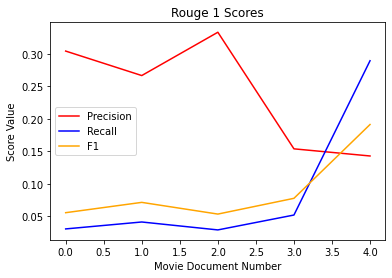

In [ ]:
import matplotlib.pyplot as plt

x_axis = range(num_of_iterations)

plt.title("Rouge 1 Scores")
plt.xlabel("Movie Document Number")
plt.ylabel("Score Value")
plt.plot(x_axis, rouge_1_precisions, color ="red", label="Precision")
plt.plot(x_axis, rouge_1_recall, color ="blue", label= "Recall")
plt.plot(x_axis, rouge_1_f1, color ="orange", label="F1")

plt.legend()
plt.show()

In [ ]:
# building up metric results for Rouge 2

rouge_2_precisions = []
rouge_2_recall = []
rouge_2_f1 = []
for each_rouge_2_score in all_rouges_2_scores:
    rouge_2_precisions.append(each_rouge_2_score.precision)
    rouge_2_recall.append(each_rouge_2_score.recall)
    rouge_2_f1.append(each_rouge_2_score.fmeasure)


In [ ]:
# analyzing rouge 2 results

avg_rouge_2_precision_score = np.average(rouge_2_precisions)
avg_rouge_2_recall_score = np.average(rouge_2_recall)
avg_rouge_2_f1_score = np.average(rouge_2_f1)

print(f'The average precision value for the rouge 2 scores is {avg_rouge_2_precision_score}')
print(f'The average recall value for the rouge 2 scores is {avg_rouge_2_recall_score}')
print(f'The average f1 value for the rouge 2 scores is {avg_rouge_2_f1_score}')



The average precision value for the rouge 2 scores is 0.007894736842105263
The average recall value for the rouge 2 scores is 0.016216216216216217
The average f1 value for the rouge 2 scores is 0.010619469026548672


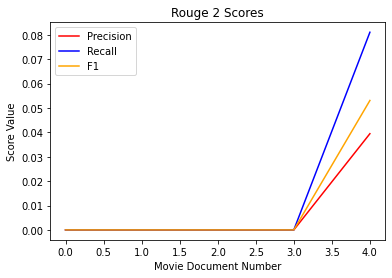

In [ ]:
# graping rouge 2 metrics

x_axis = range(num_of_iterations)

plt.title("Rouge 2 Scores")
plt.xlabel("Movie Document Number")
plt.ylabel("Score Value")
plt.plot(x_axis, rouge_2_precisions, color ="red", label="Precision")
plt.plot(x_axis, rouge_2_recall, color ="blue", label= "Recall")
plt.plot(x_axis, rouge_2_f1, color ="orange", label="F1")

plt.legend()
plt.show()